In [1]:
import logging
import json
import requests
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Polygon, Point
from folium import plugins
import folium
import numpy
import matplotlib.pyplot as plt
import utm
import random 
from typing import Tuple
import time

OPTIMIZED_ROUTE_URL = "http://localhost:8002/optimized_route" 
DEFAULT_HEADERS = {"Content-type": "application/json"}

# Use six degrees of precision when using Valhalla for routing
VALHALLA_PRECISION = 1.0 / 1e6

EARTH_RADIUS = 6371. * 1000. # In meters
 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [229]:


# distance_delta = 50
# variance = 14
# linestring = LineString([[start_x, start_y], [end_x, end_y]])
# linestring
# n = int(linestring.length // distance_delta) + 1
# subdivision = []
# for i in range(n):
#     if i == 0 or i == (n - 1):
#         subdivision.append(i)
#     else:
#         subdivision.append(i + np.random.normal(0, 1 / 10))

# print([i / float(n - 1) for i in range(n)])
# print()
# print([subdivision[i] / float(n - 1) for i in range(n)])
# points = [
#     linestring.interpolate(subdivision[i] / float(n - 1), normalized = True) for i in range(n)
# ]
# points_ = []
# for point in points:
#     rand = np.random.normal(0, variance, size = 2)
#     points_.append(
#         [point.x + rand[0], point.y + rand[1]]
#     )
# plt.scatter([p.x for p in points], [p.y for p in points])
# plt.show()
# LineString(points_)
    
# npolyline.length

# lat = []
# lon = []
# for x, y in list(npolyline.coords):
#     lat.append(x)
#     lon.append(y)

# def stop_point(x, y, n, var):
#     lats = x + np.random.normal(0, var, size = n)
#     lons = y + np.random.normal(0, var, size = n)
#     print(len(lats), len(lons))
#     return list(zip(lats, lons))

# x, y, _, _ = utm.from_latlon(start_dp.latitude, start_dp.longitude)
# sp_start = stop_point(x, y, 1, 20)

# x, y, _, _ = utm.from_latlon(end_dp.latitude, end_dp.longitude)
# sp_end = stop_point(x, y, 1, 20)

# map_ = setup_map(center)
# map_ = plot_point(start_dp, center, color = "red", map_ = map_)
# map_ = plot_point(end_dp, center, color = "blue", map_ = map_)
# map_ = plot_polyline(
#     [DataPoint(*utm.to_latlon(x, y, 32, "U")) for x, y in sp_start] + \
#     [DataPoint(*utm.to_latlon(x, y, 32, "U")) for x, y in list(npolyline.coords)[8:]] + \
#     [DataPoint(*utm.to_latlon(x, y, 32, "U")) for x, y in sp_end],
#     center,
#     color = "blue",
#     map_ = map_,
# )
# map_

# response = test_valhalla(start_dp = start_dp, end_dp = end_dp)
# dict_ = json.loads(response.content)
# for key in dict_:
#     print("Ket: ", key)
#     for item in dict_[key]:
#         print(item, dict_[key][item])
#         print()

In [54]:
## class DataPoint:
    
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude
        
class WayPoint(DataPoint):
    
    def __init__(self, latitude: float, longitude: float, duration: float = 0., variance: float = 0.):
        super().__init__(latitude = latitude, longitude = longitude)
        self.variance = variance
        self.duration = duration
        
class ValhallaInterface:

    def __init__(self) -> None:
        pass


    def decode_polyline(self, polyline_string):
        index = 0; latitude = 0; longitude = 0
        coordinates = []
        changes = {"latitude": 0, "longitude": 0}
        # Coordinates have variable length when encoded, so just keep
        # track of whether we have hit the end of the string. In each
        # while loop iteration a single coordinate is decoded.
        while index < len(polyline_string):
            # Gather latitude/longitufe changes, store them in a dictionary to apply them later
            for unit in ["latitude", "longitude"]: 
                shift, result = 0, 0
                while True:
                    byte = ord(polyline_string[index]) - 63
                    index += 1
                    result |= (byte & 0x1f) << shift
                    shift += 5
                    if not byte >= 0x20:
                        break
                if (result & 1):
                    changes[unit] = ~(result >> 1)
                else:
                    changes[unit] = (result >> 1)
            latitude += changes["latitude"]
            longitude += changes["longitude"]
            coordinates.append(
                [VALHALLA_PRECISION * latitude, VALHALLA_PRECISION * longitude],
            )
        return coordinates

    def send_optimized_route_request(self, dp1, dp2):    
        def build_optimized_route_request(dp1, dp2):
            return json.dumps({
                "locations":[
                    # Start location
                    {"lat": dp1.latitude, "lon": dp1.longitude},
                    # End location
                    {"lat": dp2.latitude, "lon": dp2.longitude},
                ],
                "costing": "pedestrian",
                "directions_options": {
                    "units":"kilometers"
                },
            })
        d = build_optimized_route_request(dp1, dp2)
        response = requests.post(
            OPTIMIZED_ROUTE_URL,
            data = d,
            headers = DEFAULT_HEADERS,
        )
        if response.status_code == 200:
            content = json.loads(response.content)
        else:
            content = None
        return content

def setup_map(center, zoom_start = 14, tiles: str = "cartodbdark_matter"):
    map_ = folium.Map(
        location = center,
        zoom_start = zoom_start,
#         tiles = tiles,
    )
    plugins.Fullscreen(
        position = "topleft"
    ).add_to(map_)
    plugins.Draw(
        filename="placeholder.geojson",
        export = True,
        position = "topleft"
    ).add_to(map_)
    return map_

def plot_point(datapoint, center, color, radius = 5.0, opacity = 1, map_ = None):
    folium.CircleMarker(
        [datapoint.latitude, datapoint.longitude],
        radius = radius,
        color = color,
        opacity = opacity,
        popup = f"...",
    ).add_to(map_)
    return map_
    
def plot_polyline(datapoints, center, color, weight: float = 2.0, opacity: float = 1, map_ = None):
        lst = []
        for datapoint in datapoints:
            lst.append([
                datapoint.latitude,
                datapoint.longitude,
            ])
        folium.PolyLine(
            lst,
            color = color,
            weight = weight,
            opacity = opacity,
            popup = f"...",
        ).add_to(map_)
        return map_

    
def test_valhalla(start_dp, end_dp):
    d = json.dumps({
        "locations":[
            {"lat": start_dp.latitude, "lon": start_dp.longitude},
            {"lat": end_dp.latitude, "lon": end_dp.longitude},
#             {"lat": 55.39594, "lon": 10.38831},
#             {"lat": 55.39500, "lon": 10.38800},
        ],
        "costing": "pedestrian",
        "directions_options": {
            "units":"kilometers"
        },
    })
    response = requests.post(
        OPTIMIZED_ROUTE_URL,
        data = d,
        headers = DEFAULT_HEADERS,
    )
    return response

def haversine_distance(
        lat_1: float, lon_1: float,
        lat_2: float, lon_2: float,
    ) -> float:
    """Calculate the 'Haversine' (great-circle) distance in meters between two locations
    / (latitude, longitude) points.

    Args:
        lat_1 (float): Latitude of location 1.
        lon_1 (float): Longitude of location 1.
        lat_2 (float): Latitude of location 2.
        lon_2 (float): Longitude of location 2.

    Returns:
        float: The distance between location 1 and 2 in meters. 
    """
    d_lat = np.radians(lat_1 - lat_2)
    d_lon = np.radians(lon_1 - lon_2)
    lat1 = np.radians(lat_1)
    lat2 = np.radians(lat_2)
    a = np.sin(d_lat / 2) * np.sin(d_lat / 2) + \
        np.sin(d_lon / 2) * np.sin(d_lon / 2) * np.cos(lat1) * np.cos(lat2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = EARTH_RADIUS * c
    return d

def rand_24_bit() -> int:
    """Returns a random 24-bit integer"""
    return random.randrange(0, 16**6)


def color_dec() -> int:
    """Alias of rand_24 bit()"""
    return rand_24_bit()


def color_hex(num: int = rand_24_bit()) -> str:
    """Returns a 24-bit int in hex"""
    return "%06x" % num


def color_rgb(num: int = rand_24_bit()) -> Tuple[int, int, int]:
    """Returns three 8-bit numbers, one for each channel in RGB"""
    hx = color_hex(num)
    barr = bytearray.fromhex(hx)
    return (barr[0], barr[1], barr[2])

   
#     def __init__(self, start, end, datapoint_distance_delta, datapoint_variance, subdivision_variance):
#         # self.waypoints = None TODO
#         self.start = start
#         self.end = end
#         self.vi = ValhallaInterface()
#         path = self.create_path()
#         self.path = self.interpolate(
#             LineString(path),
#             datapoint_distance_delta,
#             datapoint_variance,
#             subdivision_variance,
#         )

#     def __init__(self, waypoints, datapoint_distance_delta, datapoint_variance, subdivision_variance):
#         self.waypoints = waypoints
#         self.datapoint_distance_delta = datapoint_distance_delta
#         self.datapoint_variance = datapoint_variance
#         self.subdivision_variance = subdivision_variance
#         self.vi = ValhallaInterface()
#         self.path = self.create_path()
#         self.timestamps = self.create_timestamps()
        
#         self.path = self.interpolate(
#             LineString(path),
#             datapoint_distance_delta,
#             datapoint_variance,
#             subdivision_variance,
#         )
class Path:
    
    def __init__(self, waypoints, time_delta, time_delta_variance, avg_speed, var_speed, datapoint_variance):
        self.waypoints = waypoints
        self.time_delta = time_delta
        self.time_delta_variance = time_delta_variance
        self.avg_speed = avg_speed
        self.var_speed = var_speed
        self.datapoint_variance = datapoint_variance
#         self.datapoint_distance_delta = datapoint_distance_delta
#         self.datapoint_variance = datapoint_variance
#         self.subdivision_variance = subdivision_variance
        # self.timestamps = None
        self.vi = ValhallaInterface()
        self.path, self.ts = self.create_path()

#         self.timestamps = self.create_timestamps()


#     def create_timestamps(self):#, average_speed: float, variance: float):
#         if self.path is not None:
#             coords = list(self.path.coords)
#             a = np.array(coords[:-1])
#             b = np.array(coords[1:])
#             d = np.linalg.norm(a - b, axis = 1)
#             print(d / (10. * 1000 / 3600))
# #             coords = list(zip(coords[:-1], coords[1:]))
# #             print(np.array(coords))
# #             numpy.linalg.norm(coords-b)
# #             for pair in coords:
                
# #             dx =
# #             print(coords[0])
# #             print(coords[-1])
# #             for coord0, coord1 in list()
    
    def stop_point(self, x, y, duration, _):
        # dts = [0]; _dts = [0]; dxs = [0]; counter = 0
        dts = []; _dts = 0.; dxs = []; counter = 0
        lats = []; lons = []
        while True:
            dt = self.time_delta + np.abs(np.random.normal(0, self.time_delta_variance))
            dt_next = _dts + dt 
            if dt_next > duration:        
                break
            else:
                # _dts.append(dt_next)        
                _dts += dt        
                dts.append(dt)        
                lats.append(x +  np.random.normal(0, self.datapoint_variance))
                lons.append(y + np.random.normal(0, self.datapoint_variance))
                counter += 1        
        return list(zip(lats, lons)), dts
    
    def create_segment(self, waypoint0, waypoint1):
        content = self.vi.send_optimized_route_request(
            dp1 = waypoint0,
            dp2 = waypoint1,
        )
        polyline = self.vi.decode_polyline(
            content["trip"]["legs"][0]["shape"],
        )
        utm_xs = []; utm_ys = []
        for coord in polyline[1:-1]:    
            x, y, _, _ = utm.from_latlon(coord[0], coord[1])
            utm_xs.append(x); utm_ys.append(y)
        segment = list(zip(utm_xs, utm_ys))
        linestring, dts = self.interpolate(
            LineString(segment),
        )
        return list(linestring.coords), dts
    
    def get_anchor_dts(self, stop, anchor, mid):
        print("get_anchor_dts: ", stop, anchor, mid)
        
    
    def create_path(self):
        self.segments = []; self.timestamps = []
        if len(self.waypoints) >= 2:
            waypoint0 = self.waypoints[0]; waypoint1 = self.waypoints[1]
            for i in range(1, len(self.waypoints)):
                # Convert lat/lon to utm coordinates
                if i == 1:
                    start_x, start_y, _, _ = utm.from_latlon(
                        waypoint0.latitude, waypoint0.longitude,
                    )
                    sp_start, dts_start = self.stop_point(
                        start_x, start_y,
                        waypoint0.duration, waypoint0.variance,
                    )
#                     print("start segment length: ", len(sp_start))
#                     print("start dts length    : ", len(dts_start))

                end_x, end_y, _, _ = utm.from_latlon(
                    waypoint1.latitude, waypoint1.longitude,
                )
                sp_end, dts_end = self.stop_point(
                    end_x, end_y,
                    waypoint1.duration, waypoint1.variance,
                )
#                 print("end segment length: ", len(sp_end))
#                 print("end dts length    : ", len(dts_end))
                middle_segment, segment_dts = self.create_segment(
                    waypoint0 = self.waypoints[i - 1],
                    waypoint1 = self.waypoints[i],
                )

                if i == 1:
                    anchor_start = [[start_x, start_y]]
                    anchor_end = [[end_x, end_y]]
                    segment = \
                        sp_start + anchor_start + \
                        middle_segment + \
                        [[end_x, end_y]] + sp_end
                    anchor_start_dts = self.get_anchor_dts(sp_start, anchor_start, middle_segment[0])
                    anchor_end_dts = self.get_anchor_dts(sp_end, anchor_end, middle_segment[-1])
                    print("dts start: ", dts_start)
                    segment_dts[0] = self.avg_speed / np.linalg.norm(
                        np.array(anchor_start) - np.array(sp_start[-1]),
                        axis = 1
                    )
#                     dt = time_delta + np.abs(np.random.normal(0, time_delta_variance))
#                     dx = (avg_speed + np.random.normal(0, var_speed)) * dt
#                     dx_next = dxs[counter] + dx           
                    dts = [0] + dts_start + segment_dts + dts_end
                else:
                    segment = \
                        middle_segment + \
                        [[end_x, end_y]] + sp_end
                    dts = segment_dts + dts_end
                print("middle segment length: ", len(segment))
                print("middle dts length    : ", len(dts))
                if len(self.waypoints) > (i + 1):
                    latitude, longitude = utm.to_latlon(sp_end[-1][0], sp_end[-1][1], 32, "U")
                    waypoint0 = WayPoint(
                        latitude = latitude,
                        longitude = longitude,
                        variance = self.waypoints[i].variance,
                        duration = self.waypoints[i].duration,
                    )
                    # Use the next waypoint
                    waypoint1 = self.waypoints[i + 1]
                self.segments.append(segment)
                self.timestamps.append(dts)
        else:
            raise ValueError
        _path = []; _timestamps = []
        for ts in self.timestamps:
            _timestamps.extend(ts)
#             print("final ts  : ", len(_timestamps))
        for segment in self.segments:
            _path.extend(segment)
#             print("final path: ", len(_path))
        return LineString(_path), _timestamps

#     def interpolate(
#         self,
#         linestring: LineString,
#         datapoint_distance_delta: float,
#         datapoint_variance: float,
#         subdivision_variance: float,
#     ) -> LineString:
#         n = int(linestring.length // distance_delta) + 1
#         subdivision = []
#         for i in range(n):
#             if i == 0 or i == (n - 1):
#                 subdivision.append(i)
#             else:
#                 subdivision.append(i + np.random.normal(0, subdivision_variance))
#         points = [
#             linestring.interpolate(
#                 subdivision[i] / float(n - 1), normalized = True
#             ) for i in range(n)
#         ]
#         points_ = []
#         for point in points:
#             rand = np.random.normal(0, datapoint_variance, size = 2)
#             points_.append(
#                 [point.x + rand[0], point.y + rand[1]]
#             )
#         return LineString(points_)

#     def interpolate(
#         self,
#         linestring: LineString,
#     ) -> LineString:
#         n = int(linestring.length // distance_delta) + 1
#         subdivision = []
#         for i in range(n):
#             if i == 0 or i == (n - 1):
#                 subdivision.append(i)
#             else:
#                 subdivision.append(i + np.random.normal(0, subdivision_variance))
#         points = [
#             linestring.interpolate(
#                 subdivision[i] / float(n - 1), normalized = True
#             ) for i in range(n)
#         ]
#         points_ = []
#         for point in points:
#             rand = np.random.normal(0, datapoint_variance, size = 2)
#             points_.append(
#                 [point.x + rand[0], point.y + rand[1]]
#             )
#         return LineString(points_)

#     def interpolate(
#         self,
#         linestring: LineString,
#     ) -> LineString:
#         n = int(linestring.length // distance_delta) + 1
#         subdivision = []
#         for i in range(n):
#             if i == 0 or i == (n - 1):
#                 subdivision.append(i)
#             else:
#                 subdivision.append(i + np.random.normal(0, subdivision_variance))
#         points = [
#             linestring.interpolate(
#                 subdivision[i] / float(n - 1), normalized = True
#             ) for i in range(n)
#         ]
#         points_ = []
#         for point in points:
#             rand = np.random.normal(0, datapoint_variance, size = 2)
#             points_.append(
#                 [point.x + rand[0], point.y + rand[1]]
#             )
#         return LineString(points_)

    def interpolate(
        self,
        linestring: LineString,
    ) -> LineString:
        # original route linestring with values: [1:-1]
        dxs, dts = self.segment_subdivision(
            segment = linestring,
            time_delta = self.time_delta,
            time_delta_variance = self.time_delta_variance,
            avg_speed = self.avg_speed,
            var_speed = self.var_speed,
        )
        points = [linestring.interpolate(dxs[i], normalized = True) for i in range(len(dxs))]
        points_ = []
        for point in points:
            rand = np.random.normal(0, self.datapoint_variance, size = 2)
            points_.append(
                [point.x + rand[0], point.y + rand[1]]
            )
        return LineString(points_), dts
        
#         n = int(linestring.length // distance_delta) + 1
#         subdivision = []
#         for i in range(n):
#             if i == 0 or i == (n - 1):
#                 subdivision.append(i)
#             else:
#                 subdivision.append(i + np.random.normal(0, subdivision_variance))
#         points = [
#             linestring.interpolate(
#                 subdivision[i] / float(n - 1), normalized = True
#             ) for i in range(n)
#         ]
#         points_ = []
#         for point in points:
#             rand = np.random.normal(0, datapoint_variance, size = 2)
#             points_.append(
#                 [point.x + rand[0], point.y + rand[1]]
#             )
#         return LineString(points_)

    def segment_subdivision(self, segment, time_delta, time_delta_variance, avg_speed, var_speed):
        dxs = [0]; dts = [0]; counter = 0
        ls = LineString(segment); ls_length = ls.length
        while True:
            dt = time_delta + np.abs(np.random.normal(0, time_delta_variance))
            dx = (avg_speed + np.random.normal(0, var_speed)) * dt
            dx_next = dxs[counter] + dx 
            if dx_next > ls_length:        
                break
            else:
                # dts.append(dts[counter] + dt)        
                dts.append(dt)        
                dxs.append(dx_next)
                counter += 1
        normalized_dxs = [val / ls_length for val in dxs]
        return normalized_dxs, dts
    
    def to_latlon(self):
        lats = []
        lons = []
        if self.path is not None:
            for coord in self.path.coords:
                lat, lon = utm.to_latlon(coord[0], coord[1], 32, "U")
                lats.append(lat)
                lons.append(lon)
        return list(zip(lats, lons))

IndentationError: unexpected indent (<ipython-input-54-d82ca754f399>, line 3)

In [49]:
start_dp = DataPoint(
    latitude = 55.363451206145925,
    longitude = 10.412869042981713,
)
middle_dp = DataPoint(
    latitude = 55.373384555955425,
    longitude = 10.40937928427195,
)

end_dp = DataPoint(
    latitude = 55.37427658758254,
    longitude = 10.403394466623759,
)

waypoints = [
    WayPoint(
        latitude = 55.363451206145925,
        longitude = 10.412869042981713,
        duration = 120, # In seconds
        variance = 14, # In meters
    ),
    WayPoint(
        latitude = 55.373384555955425,
        longitude = 10.40937928427195,
        duration = 120, # Seconds
        variance = 14, # In meters
    ),
    WayPoint(
        latitude = 55.37427658758254,
        longitude = 10.403394466623759,
        duration = 120, # Seconds
        variance = 14, # In meters
    )
]

avg_speed = 5.                      # Average human walking speed in km/h
avg_speed = 5. * (1000 / (60 * 60)) # Average human walking speed in m/s
var_speed = 0.5
var_speed = 0.5 * (1000 / (60 * 60)) # Walking speed in m/s

time_delta = 10.
time_delta_variance = 25.

# samples = 2     # Count 
# timeperiod = 10 # In seconds between datapoints
# sampling_rate = samples / timeperiod  # Desired number of samples per second
# print("Sampling rate: ", sampling_rate)
# distance = avg_speed * timeperiod
# distance

# path = Path(
#     waypoints = waypoints,
#     time_delta = 1.,
#     time_delta_variance = 1.,
#     avg_speed = avg_speed,
#     var_speed = var_speed,
#     datapoint_variance = 15,
# )


map_ = setup_map(center)
map_ = plot_point(start_dp, center, color = "red", map_ = map_)
map_ = plot_point(middle_dp, center, color = "green", map_ = map_)
map_ = plot_point(end_dp, center, color = "blue", map_ = map_)

for _ in range(1):
    random.seed(time.time())
    color = "#" + str(color_hex(num = rand_24_bit()))
    path = Path(
        waypoints = waypoints,
        time_delta = time_delta,
        time_delta_variance = time_delta_variance,
        avg_speed = avg_speed,
        var_speed = var_speed,
        datapoint_variance = 20,
    )
    map_ = plot_polyline(
        [DataPoint(x, y) for x, y in list(path.to_latlon())],
        center,
        color = color,
        map_ = map_,
    )
# map_
# print("TS length  : ", len(path.ts))
# print("Path length: ", len(path.path.coords))
print()
for item in path.ts:
    print(item)


get_anchor_dts:  [(589536.8972118403, 6136148.217744065), (589503.5177754392, 6136111.801792596)] [[589557.1534505105, 6136145.709495366]] (589580.872535347, 6136135.047406869)
get_anchor_dts:  [(589356.346135124, 6137245.080081196), (589328.9246597169, 6137232.048358453), (589290.07327879, 6137238.803208572), (589333.5103295863, 6137220.904529358)] [[589313.5885207946, 6137246.548665806]] (589304.9623036539, 6137220.546235684)
dts start:  [49.76962891903618, 29.43710774678488]
middle segment length:  95
middle dts length    :  94
middle segment length:  17
middle dts length    :  16

0
49.76962891903618
29.43710774678488
0
15.750125668004067
51.947405958486634
48.187456879619404
19.11062160187078
34.76374813272794
19.793115374384897
25.121143330597285
33.62497819824871
12.532996902109343
23.570516036694624
12.358136959812644
28.43399854577605
36.452375328960336
34.88354628413717
20.24627576200573
13.114443319136718
44.53348178867445
39.061524874193765
29.523841409739852
19.39677780722

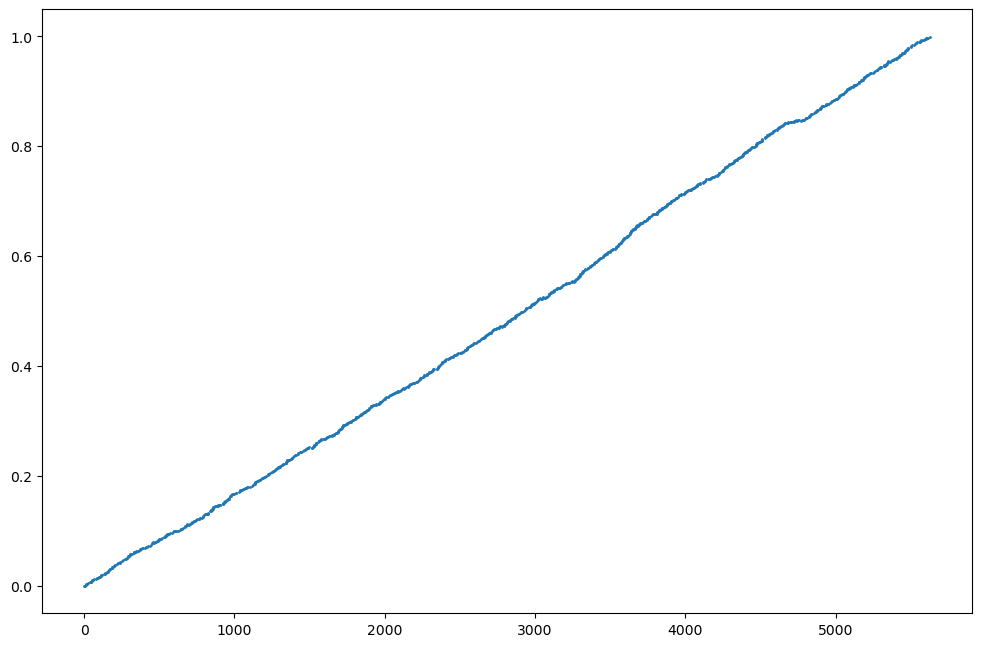

In [400]:
polyline = [
    [start_dp.latitude, start_dp.longitude],
    [middle_dp.latitude, middle_dp.longitude],
    [end_dp.latitude, end_dp.longitude],
]
utm_xs = []; utm_ys = []
for coord in polyline:    
    x, y, _, _ = utm.from_latlon(coord[0], coord[1])
    utm_xs.append(x); utm_ys.append(y)
segment = list(zip(utm_xs, utm_ys))

def random_interpolation(time_delta, time_delta_variance, avg_speed, var_speed):
    dxs = [0]; dts = [0]; counter = 0
    ls = LineString(segment); ls_length = ls.length
    while True:
        dt = time_delta + np.abs(np.random.normal(0, time_delta_variance))
        dx = avg_speed + np.random.normal(0, var_speed) * dt
        dx_next = dxs[counter] + dx 
        if dx_next > ls_length:        
            break
        else:
            dts.append(dts[counter] + dt)        
            dxs.append(dx_next)
            counter += 1
    normalized_dxs = [val / ls_length for val in dxs] 
    return normalized_dxs, dts

dxs, dts = random_interpolation(
    time_delta = time_delta,
    time_delta_variance = time_delta_variance,
    avg_speed = avg_speed,
    var_speed = var_speed,
)

plt.scatter(dts, dxs, s = 1)
plt.show()
# dxs
# LineString(segment).length
# avg_speed
# n = int(linestring.length // distance_delta) + 1
# subdivision = []
# for i in range(n):
#     if i == 0 or i == (n - 1):
#         subdivision.append(i)
#     else:
#         subdivision.append(i + np.random.normal(0, subdivision_variance))
# points = [
#     linestring.interpolate(
#         subdivision[i] / float(n - 1), normalized = True
#     ) for i in range(n)
# ]
# points_ = []
# for point in points:
#     rand = np.random.normal(0, datapoint_variance, size = 2)
#     points_.append(
#         [point.x + rand[0], point.y + rand[1]]
#     )
# return LineString(points_)

In [273]:
# for coord in list(path.path.coords):
#     print(coord)
#     break

# path.path.length

avg_speed = 5.                      # Average human walking speed in km/h
avg_speed = 5. * (1000 / (60 * 60)) # Average human walking speed in m/s
var_speed = 0.5
samples = 2     # Count 
timeperiod = 10 # In seconds between datapoints
sampling_rate = samples / timeperiod  # Desired number of samples per second
print("Sampling rate: ", sampling_rate)
distance = avg_speed * timeperiod
distance

Sampling rate:  0.2


13.88888888888889

In [7]:
center = [55.39594, 10.38831]

# map_ = setup_map(center)
# map_ = plot_point(start_dp, center, color = "red", map_ = map_)
# map_ = plot_point(end_dp, center, color = "blue", map_ = map_)
# map_ = plot_polyline(
#     [start_dp] + [DataPoint(x, y) for x, y in polyline] + [end_dp],
#     center,
#     color = "blue",
#     map_ = map_,
# )
# map_

In [24]:
# np.random.seed(20)
def sample_path_batch(M, N):
    dt = 1.0 / (N - 1)
    dt_sqrt = numpy.sqrt(dt)
    B = numpy.empty((M, N), dtype=numpy.float32)
    B[:, 0] = 0
    for n in range(N - 2):                                           
        t = n * dt
        xi = numpy.random.randn(M) * dt_sqrt
        B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
    B[:, -1] = 0
    return B

# nvals = sample_path_batch(1, 10 + 1)[0]
# ovals = [i + 10 for i in range(2)]
# uvals = [i * 10 for i in range(len(ovals))]

# # using the variable axs for multiple Axes
# fig, axs = plt.subplots(3, 1, sharex = True, sharey = True)

# axs[0].scatter(uvals, ovals)
# axs[1].scatter([i for i in range(len(nvals))], nvals)

# avals = []
# for i in range(2, len(ovals) + 1):
#     vvals = ovals[i - 2:i]
# #     min_lon = np.min(ovals[i - 2:i])
# #     max_lon = np.max(ovals[i - 2:i])
# #     min_lat = np.min(ovals[i - 2:i])
# #     max_lat = np.max(ovals[i - 2:i])
#     for j in range(len(nvals)):
#         j_val = nvals[j]
#         # min_val = np.min(nvals)
#         # max_val = np.max(nvals)
#         nval = j_val + (vvals[0] *(uvals[1] - j) + vvals[1] * (j - uvals[0])) / (uvals[1] - uvals[0])
#         # nval = min_lon + ((j_val - min_val) * (max_lon - min_lon)) / (max_val - min_val)
#         avals.append(nval)

# axs[2].scatter([i for i in range(len(avals))], avals)

# # plt.scatter([i for i in range(len(values))], values)
# # plt.plot([i for i in range(len(values))], values)
# plt.show()


1 1
1 1


In [32]:
print(transformed_values_lon)

[10.412869042981713, 10.412869042981713, 10.412869042981713, 10.412869042981715, 10.412869042981715, 10.412869042981713, 10.412869042981715, 10.412869042981715, 10.412869042981713, 10.412869042981713, 10.412869042981713]


In [9]:
# lon_nvals = []
# lat_nvals = []
# dist = 10.
# for i in range(2, len(polyline) + 1):
#     min_lon = np.min(lon[i - 2:i])
#     max_lon = np.max(lon[i - 2:i])
#     min_lat = np.min(lat[i - 2:i])
#     max_lat = np.max(lat[i - 2:i])
#     # NOTE: Use one brownian bridge at the moment
#     values = sample_path_batch(1, 3)[0]
#     for j in range(len(values)):
#         j_val = values[j]
#         min_val = np.min(values)
#         max_val = np.max(values)
#         nval = min_lon + ((j_val - min_val) * (max_lon - min_lon)) / (max_val - min_val)
#         if j != 0 and j != len(values):
#             lon_nvals.append(nval)
#     values = sample_path_batch(1, 3)[0]
#     for j in range(len(values)):
#         j_val = values[j]
#         min_val = np.min(values)
#         max_val = np.max(values)
#         nval = min_lat + ((j_val - min_val) * (max_lat - min_lat)) / (max_val - min_val)
#         if j != 0 and j != len(values):
#             lat_nvals.append(nval)
#     if i == 1:
#         break

# coords = zip(lat_nvals, lon_nvals)
# # haversine_distance()

# #     print(min_lon - min_lon / (max_lon - min_lon))
# #     print(max_lon - min_lon / (max_lon - min_lon))
# #     print(lon[i - 2:i])

In [104]:
lon_nvals = []
lat_nvals = []
param = 100
# for i in range(2, len(polyline) + 1):
for i in range(2, len(list(npolyline.coords)) + 1):
    min_lon = np.min(lon[i - 2:i])
    max_lon = np.max(lon[i - 2:i])
    min_lat = np.min(lat[i - 2:i])
    max_lat = np.max(lat[i - 2:i])
    lon_vals = lon[i - 2:i]
    lat_vals = lat[i - 2:i]
    indices = [i for i in range(param + 1)]
    values = sample_path_batch(1, param + 1)[0]
    # NOTE: Use one brownian bridge at the moment
    for j in range(len(values)):
        j_val = values[j]
        min_val = np.min(values)
        max_val = np.max(values)
#         nval = (lon_vals[0] * (indices[-1] - j) + lon_vals[1] * (j - indices[0])) / (indices[-1] - indices[0])
#         rej_val = min_lon + ((j_val - min_val) * (max_lon - min_lon)) / (max_val - min_val)
        rej_val = ((j_val - min_val) * (max_lon - min_lon)) / (max_val - min_val)
        nval = rej_val + (lon_vals[0] * (indices[-1] - j) + lon_vals[1] * (j - indices[0])) / (indices[-1] - indices[0])
        if j != 0:# and j != len(values):
            lon_nvals.append(nval)
    values = sample_path_batch(1, param + 1)[0]
    for j in range(len(values)):
        j_val = values[j]
        min_val = np.min(values)
        max_val = np.max(values)
        rej_val = ((j_val - min_val) * (max_lat - min_lat)) / (max_val - min_val)
        nval = rej_val + (lat_vals[0] * (indices[-1] - j) + lat_vals[1] * (j - indices[0])) / (indices[-1] - indices[0])
        if j != 0: # and j != len(values):
            lat_nvals.append(nval)

new_latvals = []
new_lonvals = []
for i in range(len(lat_nvals)):
    x, y = utm.to_latlon(lat_nvals[i], lon_nvals[i], 32, "U")
    new_latvals.append(x)
    new_lonvals.append(y)

# coords = zip(lat_nvals, lon_nvals)
coords = zip(new_latvals, new_lonvals)

# # plt.plot(lon_nvals, lat_nvals)
# plt.plot(new_latvals, new_lonvals)
# plt.show()
# len(list(npolyline.coords))
# len(list(lat_nvals))
# for item in coords:
#     print(item)

In [105]:
map_ = setup_map(center)
map_ = plot_point(start_dp, center, color = "red", map_ = map_)
map_ = plot_point(end_dp, center, color = "blue", map_ = map_)
map_ = plot_polyline(
    [start_dp] + [DataPoint(x, y) for x, y in coords] + [end_dp],
    center,
    color = "blue",
    map_ = map_,
)
map_
# map_ = setup_map(center)
# map_ = plot_point(start_dp, center, color = "red", map_ = map_)
# map_ = plot_point(end_dp, center, color = "blue", map_ = map_)
# for point in [DataPoint(x, y) for x, y in coords]:
#     map_ = plot_point(point, center, color = "green", map_ = map_)
# map_ = plot_polyline([DataPoint(x, y) for x, y in coords], center, color = "blue", map_ = map_)
# map_
# plt.scatter([i for i in range(len(lat_nvals))], lat_nvals, s= 5)

# plt.scatter(lon[:1], lat[:1], s = 25, color = "red")
# plt.scatter(lon_nvals, lat_nvals, s = 5)
# plt.scatter([i for i in range(len(lat[:10]))], lat[:10], s = 25, color = "red")
# plt.scatter([i for i in range(len(lon_nvals))], lon_nvals, s = 5)

# plt.scatter([i for i in range(len(lat))], lat, s= 2.5)
# plt.plot(lon_nvals, lat_nvals)
# plt.show()

In [12]:
# map_ = setup_map(center)
# map_ = plot_point(start_dp, center, color = "red", map_ = map_)
# map_ = plot_point(end_dp, center, color = "blue", map_ = map_)
# map_ = plot_polyline(
#     [start_dp] + [DataPoint(x, y) for x, y in polyline] + [end_dp],
#     center,
#     color = "blue",
#     map_ = map_,
# )
# map_